In [72]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from tqdm.notebook import tqdm

import torch
import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy, UnwhitenedVariationalStrategy

from pymc3.gp.util import plot_gp_dist

In [73]:
%config InlineBackend.figure_format = "retina"
sns.set()

In [74]:
# Set seed
np.random.seed(123)

# Utility models

In [75]:
def u_pow(x, theta): return x**theta

In [76]:
def u_exp(x, theta): return 1 - np.exp(-theta*x)

In [77]:
def u_lin(x, theta=None): return x

# Generate choice data

In [78]:
def generate_data(u, seed=123, max_x=1, n=100, tau=3.333, theta=0.5):
    
    np.random.seed(seed)
    
    data = pd.DataFrame(np.random.uniform(0, 1, size=(n*10, 4)), columns=["p0", "x0", "p1", "x1"])
    for i in range(2):
        data[f"x{i}"] = data[f"x{i}"].values * max_x
    data = data[~((data.p0 >= data.p1) & (data.x0 >= data.x1))]
    data = data[~((data.p1 >= data.p0) & (data.x1 >= data.x0))]
    data = data.sample(n=n, replace=False)
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    
    seu0 = p0 * u(x0, theta)
    seu1 = p1 * u(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu)
    choices = np.zeros(n, dtype=int)
    choices[:] = p_choice_1 > np.random.random(size=n)
    data['choices'] = choices

    return data

In [79]:
data = generate_data(u=u_pow, n=1000, tau=3.333, theta=(0.5, ))
data

,p0,x0,p1,x1,choices
9002,0.696389,0.007647,0.617248,0.282997,1
7863,0.953285,0.292898,0.380948,0.552913,1
7455,0.060678,0.327938,0.685627,0.158464,1
3414,0.138550,0.276750,0.788651,0.125342,0
5796,0.116159,0.356232,0.732859,0.310642,0
...,...,...,...,...,...
2857,0.928569,0.159319,0.006656,0.571188,0
5417,0.621396,0.103035,0.601608,0.871169,1
1854,0.218694,0.560962,0.389658,0.026879,1
8834,0.980679,0.073375,0.877985,0.777087,1


# Likelihood whole model given M, $\theta_M$

In [80]:
def softplus(x):
    return np.log(1 + np.exp(x))

def objective(param, data, u_m):
    
    param = softplus(param)  # All parameters all supposed to be R+
    
    tau = param[0]
    theta = param[1]
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values 
    
    seu0 = p0 * u_m(x0, theta)
    seu1 = p1 * u_m(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu) # p choose 1
    p_choice_y = p_choice_1**y * (1-p_choice_1)**(1-y)
    return - np.log(p_choice_y).sum()

In [81]:
def optimize(data, u_m=u_pow, x0=None):
    if x0 is None:
        x0 = (0.0, 0.0) # Assume two parameters
    opt = scipy.optimize.minimize(objective, x0=x0, args=(data, u_m))
    return softplus(opt.x)

In [82]:
optimize(data, u_m=u_pow)

array([3.28496491, 0.53506426])

# Utility models

In [83]:
def u_pow(x, theta): return x**theta

In [84]:
def u_exp(x, theta): return 1 - np.exp(-theta*x)

In [85]:
def u_lin(x, theta=None): return x

# Generate choice data

In [165]:
def generate_data(u, seed=123, max_x=1, n=100, tau=3.333, theta=0.5):
    
    np.random.seed(seed)
    
    data = pd.DataFrame(np.random.uniform(0, 1, size=(n*10, 4)), columns=["p0", "x0", "p1", "x1"])
    for i in range(2):
        data[f"x{i}"] = data[f"x{i}"].values * max_x
    data = data[~((data.p0 >= data.p1) & (data.x0 >= data.x1))]
    data = data[~((data.p1 >= data.p0) & (data.x1 >= data.x0))]
    data = data.sample(n=n, replace=False)
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    
    seu0 = p0 * u(x0, theta)
    seu1 = p1 * u(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu)
    choices = np.zeros(n, dtype=int)
    choices[:] = p_choice_1 > np.random.random(size=n)
    data['choices'] = choices

    return data

In [166]:
data = generate_data(u=u_pow, n=200, tau=33.333, theta=(0.5, ))
data

,p0,x0,p1,x1,choices
308,0.710046,0.972624,0.916240,0.971488,1
771,0.254806,0.549418,0.933566,0.436220,1
1168,0.846783,0.135510,0.504619,0.547520,1
977,0.800907,0.270393,0.591541,0.534649,1
852,0.832668,0.260333,0.366150,0.920683,0
...,...,...,...,...,...
1322,0.834019,0.068404,0.111335,0.536288,0
824,0.012429,0.509863,0.981862,0.232335,1
1028,0.018290,0.849445,0.396082,0.844821,1
1246,0.338320,0.925665,0.968984,0.663299,1


# Likelihood whole model given M, $\theta_M$

In [167]:
def softplus(x):
    return np.log(1 + np.exp(x))

def objective(param, data, u_m):
    
    param = softplus(param)  # All parameters all supposed to be R+
    
    tau = param[0]
    theta = param[1]
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values 
    
    seu0 = p0 * u_m(x0, theta)
    seu1 = p1 * u_m(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu) # p choose 1
    p_choice_y = p_choice_1**y * (1-p_choice_1)**(1-y)
    return - np.log(p_choice_y).sum()

In [168]:
def optimize(data, u_m=u_pow, x0=None):
    if x0 is None:
        x0 = (0.0, 0.0) # Assume two parameters
    opt = scipy.optimize.minimize(objective, x0=x0, args=(data, u_m))
    return softplus(opt.x)

In [169]:
optimize(data, u_m=u_pow)

array([27.27818524,  0.51735924])

In [170]:
p0 = data.p0.values
p1 = data.p1.values
x0 = data.x0.values
x1 = data.x1.values
y = data.choices.values

x = np.hstack((x0, x1))
p = np.hstack((p0, p1))

x_order = np.argsort(x)
x_sorted = x[x_order]
p_sorted = p[x_order]
init_order = np.argsort(x_order)

# M = uX

# if use_ratio:
#     factor = uX * uX[:, None]
# else:
#     factor = 1.
    
n_y = len(y)

In [171]:
train_x = torch.from_numpy(x_sorted.astype(np.float32))
train_y = torch.from_numpy(y.astype(np.float32))
p = torch.from_numpy(p_sorted.astype(np.float32))

In [172]:
inducing_points = torch.linspace(0, 1, 50)  #rand(50)

In [225]:
class CustomBernoulliLikelihood(_OneDimensionalLikelihood):

    def forward(self, function_samples, **kwargs):
        raise NotImplementedError

    def log_marginal(self,  *args, **kwargs):
        raise NotImplementedError

    def marginal(self, function_dist, **kwargs):
        raise NotImplementedError

    def expected_log_prob(self, observations, function_dist, *params, **kwargs):
        L = torch.linalg.cholesky(function_dist.covariance_matrix)
        m = function_dist.loc
        rd = torch.randn(m.size(0))
        f = m + L@rd
        
        est_eu_sorted =  p * f    
        est_eu = est_eu_sorted[init_order]

        est_diff_eu = est_eu[n_y:] - est_eu[:n_y]
        
        p_choose_1 = torch.sigmoid(33.333*est_diff_eu)
        log_prob = torch.log(p_choose_1**observations*(1-p_choose_1)**(1-observations)+1e-07)
        
        
        return log_prob

In [300]:
def u(x):
    return x**0.5

In [305]:
class MeanFunc(gpytorch.means.mean.Mean):
    def forward(self, x):
        return u(x).squeeze(-1)        

In [309]:
class CustomKernel(gpytorch.kernels.ScaleKernel):
    
    def __call__(self, x1, x2=None, *args, **kwargs):
        if x2 is None:
            x2 = x1
        return  u(x1) * u(x2.T) * super(CustomKernel, self).__call__(x1, x2, *args, **kwargs)

In [310]:
class GPClassificationModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=False
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = MeanFunc()
        self.covar_module = CustomKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
model = GPClassificationModel(inducing_points=inducing_points)
likelihood = CustomBernoulliLikelihood()

In [311]:
training_iter = 500


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())


iterator = tqdm(range(training_iter))

for i in iterator:
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    
    optimizer.step()
    
    iterator.set_postfix(loss=loss.item())

  0%|          | 0/500 [00:00<?, ?it/s]

In [312]:
test_x = torch.linspace(0, 1, 101)
f_preds = model(test_x)

In [313]:
pred = f_preds.sample(torch.Size((1000,))).numpy()

In [314]:
pred.shape

(1000, 101)

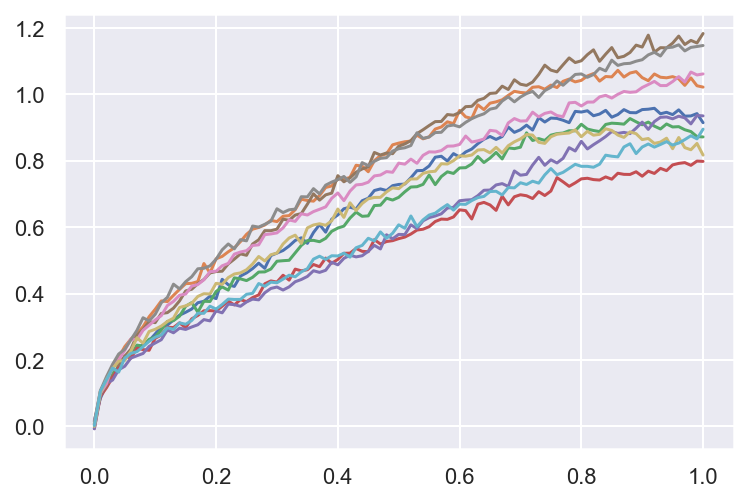

In [315]:
fig, ax = plt.subplots()
for i in range(10):
    ax.plot(test_x, pred[i])

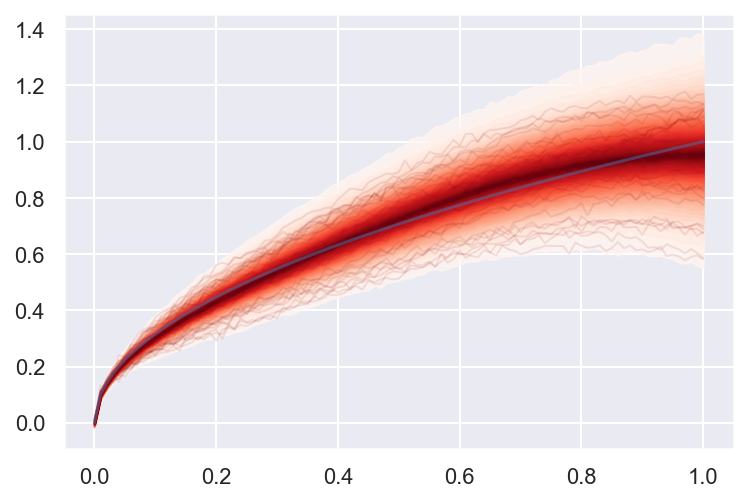

In [316]:
fig, ax = plt.subplots()
plot_gp_dist(ax, pred, test_x)
ax.plot(test_x, u_pow(test_x, 0.5), alpha=0.5)